# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.



## Camera Calibration
show how to calibration the camera
1. get the chessboard used cv2.findChessboardCorners: def get_chessboard(glob_dir='camera_cal/calibration*.jpg'):
2. show the chessboard used cv2.drawChessboardCorners: def show_chess(imgs):
3. get the calibrate matrix used cv2.calibrateCamera :def calibrate_camera(objpoints, imgpoint, img):
4. calibrate the camera used cv2.undistort :  def calibrate_camera(objpoints, imgpoint, img):

In [91]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline


In [92]:
def get_chessboard(glob_dir='camera_cal/calibration*.jpg'):
    """
    return objpoints, imgpoints, chess_imgs
    get the chessboard from the imgs in glob_dir
    """
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    chess_imgs = [] #array of images which has chessboard
    # Make a list of calibration images
    images = glob.glob(glob_dir)
    
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
        
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            chess_imgs.append(img)
        else:
            print("ret==false: ",fname)
    return objpoints, imgpoints, chess_imgs

In [93]:
def show_chess(imgs):
    """
    show the imgs.
    """
    length = len(imgs)
    row = int(length/3) + 1
    %matplotlib inline
    fig, axs = plt.subplots(row, 3, figsize=(35, 35))
    # fig.subplots_adjust(hspace = .2, wspace=.001)
    axis = axs.ravel()
    print("The chessboards: ")
    i = 0
    for img in imgs:        
        axis[i].axis('off')
        axis[i].imshow(img)
        i = i + 1

ret==false:  camera_cal/calibration4.jpg
ret==false:  camera_cal/calibration5.jpg
ret==false:  camera_cal/calibration1.jpg
The chessboards: 


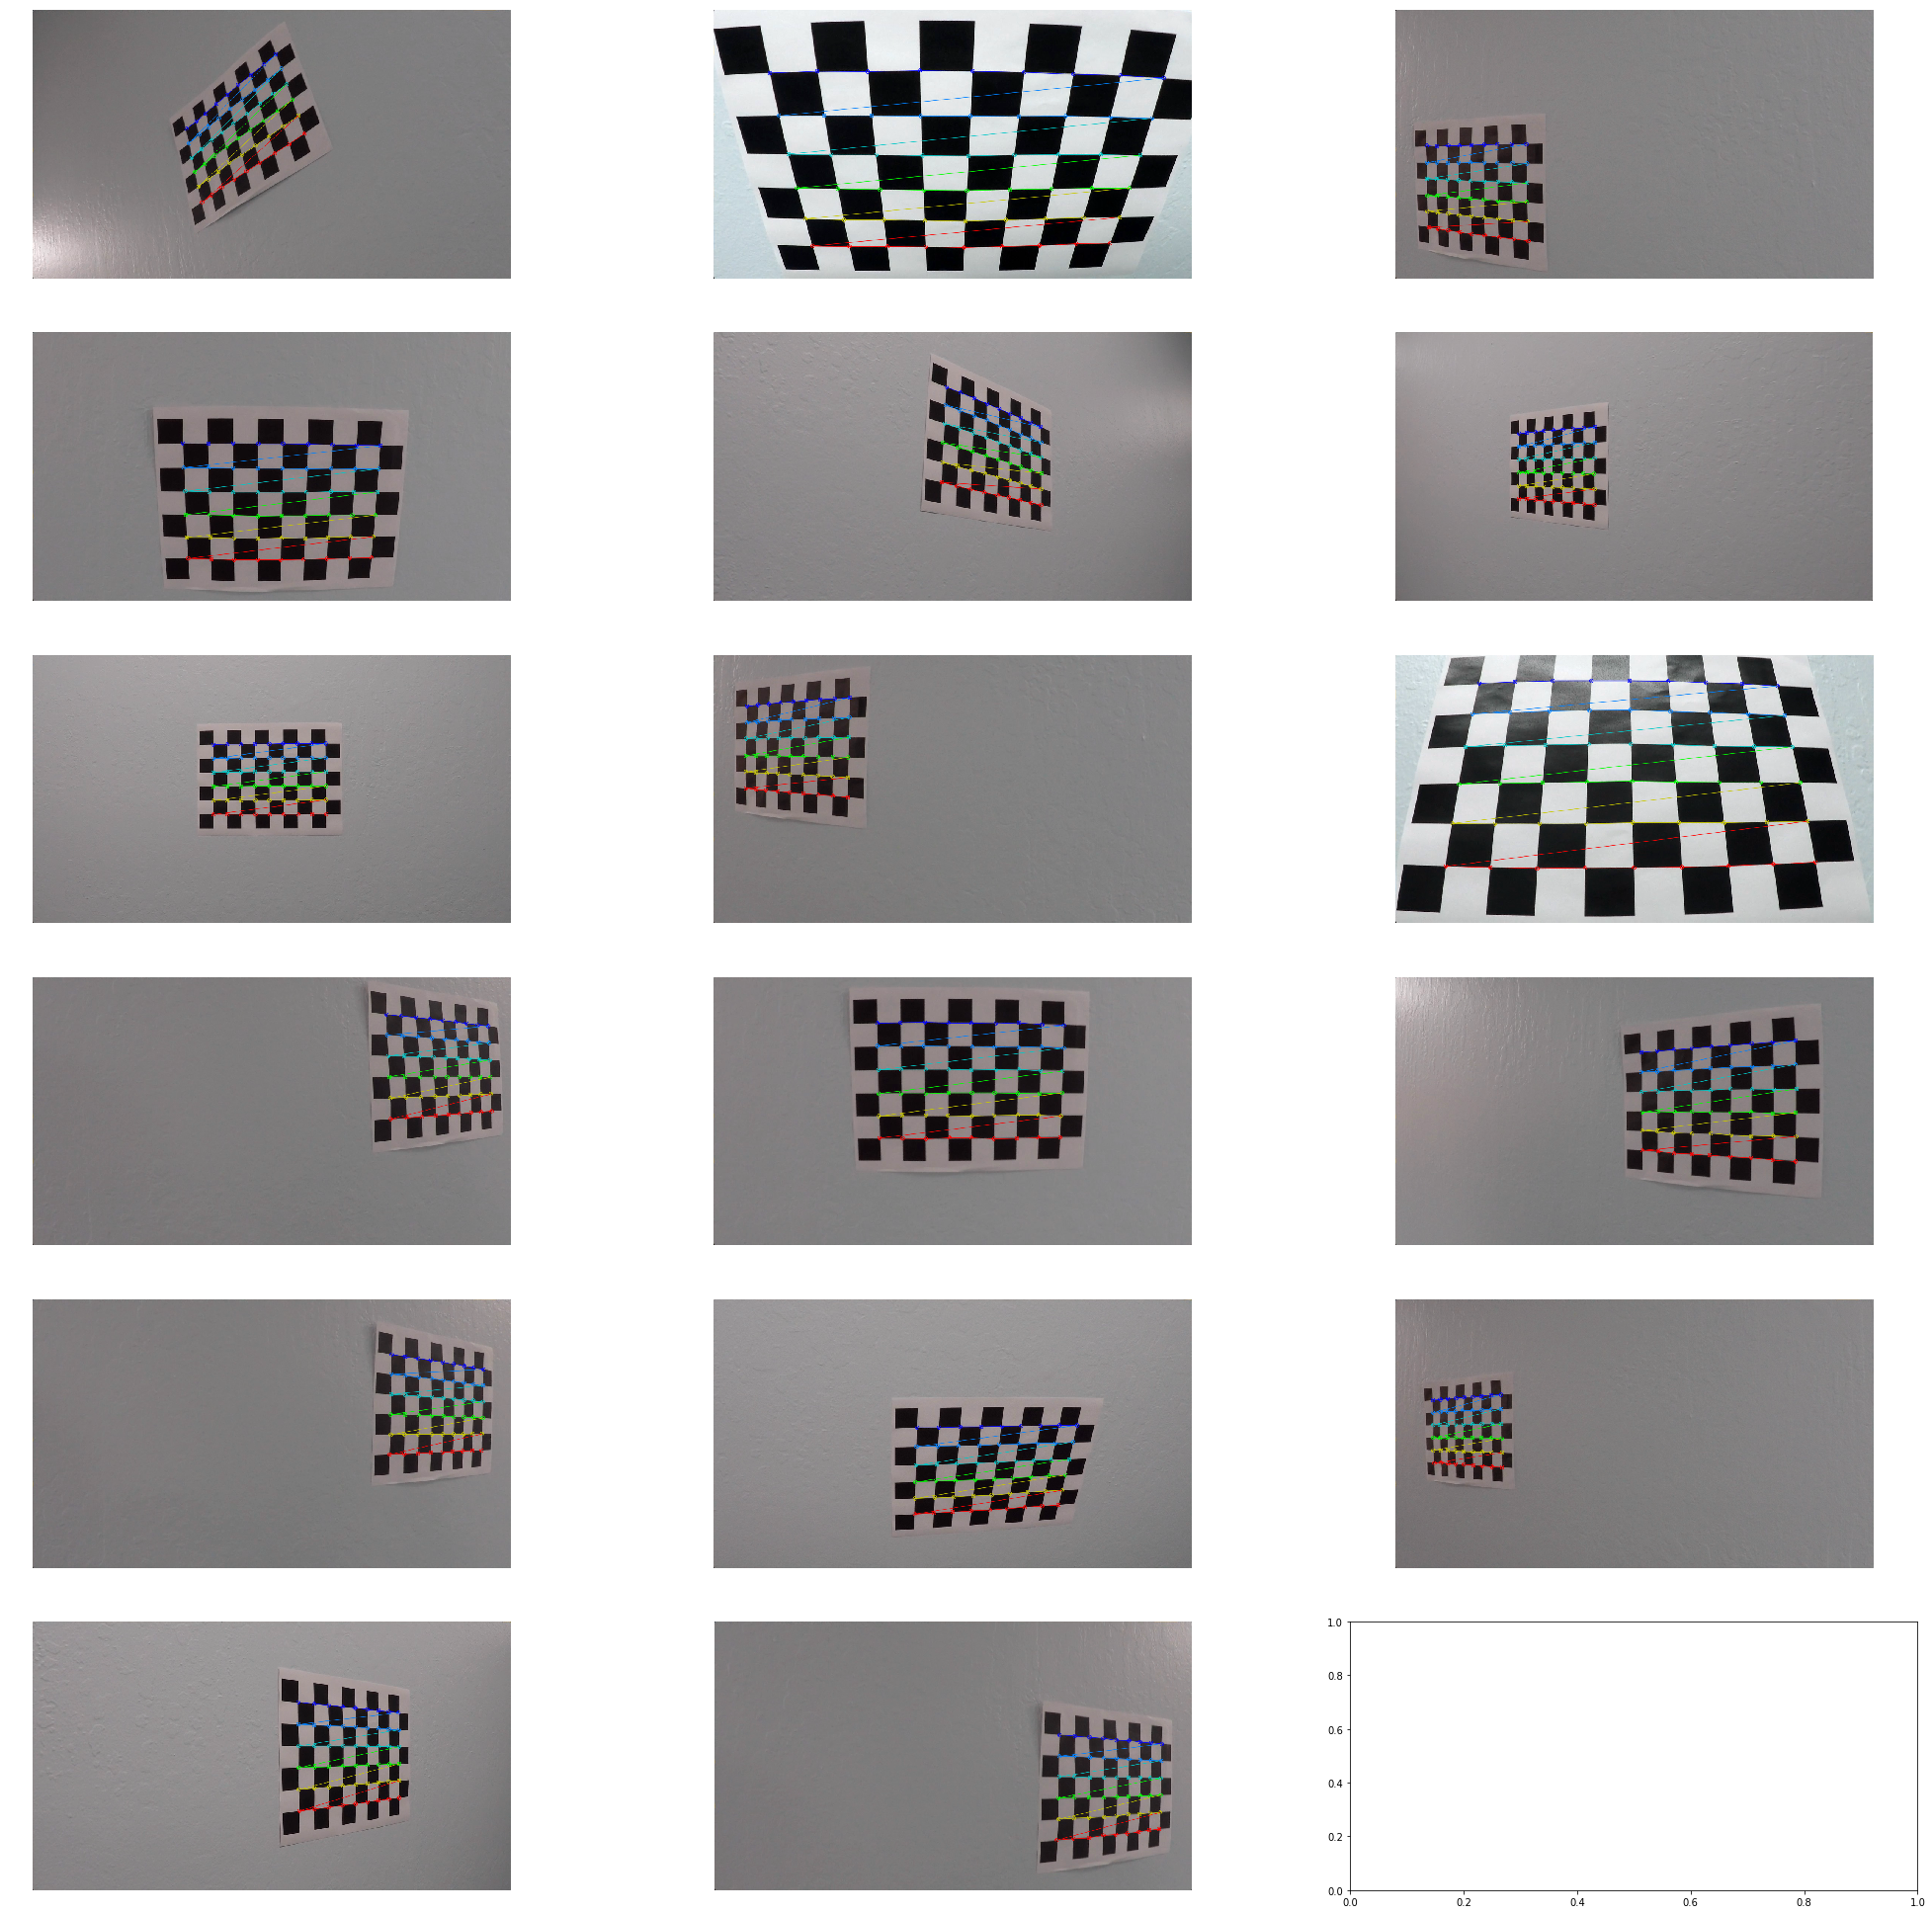

In [94]:
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
chess_imgs = [] #array of images which has chessboard
objpoints, imgpoints, chess_imgs = get_chessboard(glob_dir='camera_cal/calibration*.jpg')
show_chess(chess_imgs)

In [95]:
def calibrate_camera(objpoints, imgpoint, img):
    """
    return the matrix and undistort imgs
    """
    # Test undistortion on an image
    img_size = img.shape[0:2]

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    return ret, mtx, dist, undist
    

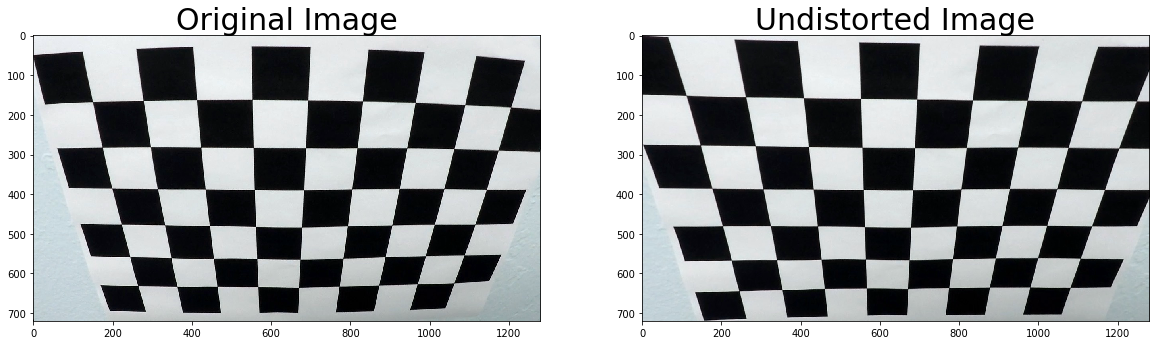

In [107]:
test_img='./camera_cal/calibration1.jpg'
undist='./output_images/undist_calibration1.jpg'


img = cv2.imread(test_img)
ret, mtx, dist, dst = calibrate_camera(objpoints, imgpoints, img)

cv2.imwrite(undist, dst)

#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

Finally calibration : ret, mtx, dist, dst = calibrate_camera(objpoints, imgpoints, img)

## undistort_image
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [114]:
def corners_unwarp(img, mtx, dist, nx = 9, ny = 6):
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    
    undist_gray = cv2.cvtColor(undist_img, cv2.COLOR_BGR2GRAY)
    
    undist_ret, undist_corners = cv2.findChessboardCorners(undist_gray, (nx,ny), None)
    img_size = (undist_gray.shape[1], undist_gray.shape[0])

    src = np.float32([undist_corners[0],undist_corners[nx - 1],undist_corners[-1],undist_corners[-nx]])
    offset = 100 # offset for dst points
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                            [img_size[0]-offset, img_size[1]-offset], 
                            [offset, img_size[1]-offset]])
    # dst =np.float32([[ 450 ,130], [1100  ,  230 ],[1100  ,  680  ], [ 450  , 770  ]])

    M = cv2.getPerspectiveTransform(src, dst)
    
    warped = cv2.warpPerspective(undist_img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M

In [115]:
img = cv2.imread('test_images/straight_lines1.jpg')
top_down, perspective_M = corners_unwarp(img,mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



TypeError: 'NoneType' object is not subscriptable